# All settings will be given to the channel 1 output, in the Direct out DAC configuration

In [12]:
%matplotlib widget 

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from time import sleep
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *
from PulseFiles import *
from Instrument import *
import pyqtgraph as pg 
import nidaqmx

In [2]:
M8190A.write('SEQ:DEL:ALL')

NameError: name 'M8190A' is not defined

# Visa interface for the M8190A instrument:

In [2]:
M8190A = VisaR(AWG_Settings4,60000)

In [3]:
Initialization(M8190A,AWG_Settings4)

NameError: name 'M8190A' is not defined

In [5]:
M8190A.query('*IDN?')

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2'

In [4]:
M8190A.write('*RST')

5

In [5]:
M8190A.query('FREQ:RAST?')

'5.00000000000000E+08'

In [18]:
M8190A.query(':DAC:VOLT:AMPL?')

'7.00000000000000E-01'

In [5]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [4]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


# Loading and triggering a single waveform:

In [4]:
M8190A.query('ARM:TRIG:LEV?')

'1.00000000000000E+00'

In [6]:
M8190A.write('ABOR')

5

In [5]:
test_run = Triggered_Sequence_Setup(PList_secondsA,PList_secondsB,10,5,15,7500000,M8190A,AWG_Settings4,1)

Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND


In [18]:
test_run[0]['Y1']*AWG_Settings4['Voltage Amplitude']

0           0.0
1          40.0
2          40.0
3          40.0
4          40.0
           ... 
7499995     0.0
7499996     0.0
7499997     0.0
7499998     0.0
7499999     0.0
Name: Y1, Length: 7500000, dtype: float64

In [7]:
test_run[1]['Y1']*AWG_Settings4['Voltage Amplitude']

0           0.0
1          40.0
2          40.0
3          40.0
4          40.0
           ... 
7499995     0.0
7499996     0.0
7499997     0.0
7499998     0.0
7499999     0.0
Name: Y1, Length: 7500000, dtype: float64

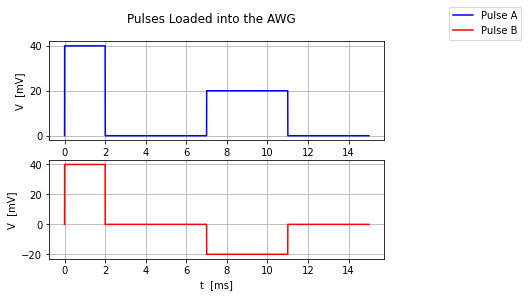

In [6]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulses Loaded into the AWG')


ax[0].plot(test_run[2],test_run[0]['Y1']*AWG_Settings4['Voltage Amplitude'],label= 'Pulse A',color='blue')
ax[1].plot(test_run[2],test_run[1]['Y1']*AWG_Settings4['Voltage Amplitude'],label= 'Pulse B',color='red')
ax[0].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_ylabel('V  [mV]')
ax[1].set_xlabel('t  [ms]')

#ax.set_title('Pulses Loaded into the AWG')

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

#fig.savefig('Pulse_scheme_15ms_7500000',optimize=True,bbox_inches='tight')

Triggering Pulse Stoped


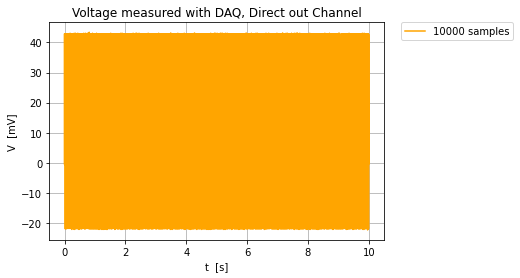

In [5]:
dataM, timeM = DAQ_Measuring(DAQ_Settings1,1000,10,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

plt.plot(timeM,dataM*1000,label= '{b} samples'.format(b=len(dataM)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title('Voltage measured with DAQ, Direct out Channel')
#ax.legend(loc=0)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement noise0',bbox_inches='tight')

In [3]:
def DAQ_Measuring_Markers(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime) 
    measuring_time = np.linspace(0,playingtime,samples)

    instrument.write('INIT:IMM')
    time.sleep(5)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
    #current_tast = nidaqmx.Task()

    #current_tast.ai_channels.add_ai_current_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input Waveform']),min_val=DAQ_settings['Minimum Current'],max_val=DAQ_settings['Maximum Current'], units=CurrentUnits.AMPS)


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input Waveform']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input Marker']),min_val=DAQ_settings['Minimum Voltage Marker'],max_val= DAQ_settings['Maximum Voltage Marker'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [7]:
dataM[0]

array([-0.00057706, -0.00041243,  0.04255541, ..., -0.00057706,
       -0.00074168,  0.0211538 ])

In [13]:
#dataM, timeM = DAQ_Measuring_Markers(DAQ_Settings1,1000,10,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

#plt.plot(timeM,dataM[0]*1000,label= '{b} samples'.format(b=len(dataM[0])),color='orange')
plt.plot(timeM,dataM[1]*1000,label= 'Marker Channel {chan}'.format(chan=DAQ_Settings1['Analog Channel Input Marker']),color='purple')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title('Voltage measured with DAQ, Direct out Channel')
#ax.legend(loc=0)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement noise0',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Different behaviour when initializing the AWG outside of the DAQ_measurement function (or inside, but with a time.sleep() right after it) and when initializing the AWG inside the function. Initializing with a delay gives "proper" measurement scheme (I still have to check whether it is getting the correct time scale). This independant of the delay time present when loading a waveform to the awg for the first time after reseting.

In [16]:
dataM.size

10000

output waveform looks better when offset value is set to 0.3mV

In [10]:
a = 3# * e-1

In [13]:
M8190A.write(':DAC1:VOLT:OFFS 0.00{value}'.format(value = a ))

22

Pump = 40mV

ProbeA = 20mV

ProbeB = - 20mV

In [20]:
def DAQ_Measuring_ms_markers(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      This DAQ maximum sampling rate of 400 KS/s for a single channel.  If you have more than 1 channel this max rate will decrease.
      For example for 5 channels you will have a max sampling rate of 50 kS/s.


      playingtime should be in seconds. it will be converted to mili seconds
      triggerinvoltage should be in volts.
    """
    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime*1e-3) 
    measuring_time = np.linspace(0,playingtime,samples)

    instrument.write('INIT:IMM')
    time.sleep(5)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
    #current_tast = nidaqmx.Task()

    #current_tast.ai_channels.add_ai_current_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input Waveform']),min_val=DAQ_settings['Minimum Current'],max_val=DAQ_settings['Maximum Current'], units=CurrentUnits.AMPS)


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input Waveform']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input Marker']),min_val=DAQ_settings['Minimum Voltage Marker'],max_val= DAQ_settings['Maximum Voltage Marker'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [15]:
def DAQ_Measuringms(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(5)



    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime*1e-3) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [30]:
M8190A.write('SOUR:MARK1:SYNC:VOLT:AMPL 0.05')
M8190A.write('SOUR:MARK1:SYNC:VOLT:OFFS 0.0020')

33

In [31]:
dataMs, timeMs = DAQ_Measuring_ms_markers(DAQ_Settings1,200000,32,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

plt.plot(timeMs,dataMs[1]*1000,label= 'Marker Channel {chan}'.format(chan=DAQ_Settings1['Analog Channel Input Marker']),color='purple')
plt.plot(timeMs,dataMs[0]*1000,label= '{b} samples'.format(b=len(dataMs[0])),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Voltage measured with DAQ, Direct out Channel DAC, Voltage Offset = 3mV, MArker Ampl = 50mV ')
ax.legend(loc=0)
#plt.legend(bbox_to_anchor=(2.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement offset {value}mV '.format(value = a ),bbox_inches='tight')

Triggering Pulse Stoped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [11]:
dataMs, timeMs = DAQ_Measuringms(DAQ_Settings1,400000,32,M8190A)

fig,ax= plt.subplots()
ax.grid(True)
a = 3
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(timeMs,dataMs*1000,label= '{b} samples'.format(b=len(dataMs)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Voltage measured with DAQ, Direct out Channel DAC, Voltage Offset = {value}mV '.format(value = a))
ax.legend(loc=0)
#plt.legend(bbox_to_anchor=(2.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement offset {value}mV '.format(value = a ),bbox_inches='tight')

Triggering Pulse Stoped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Mergin Sweeping loading function with DAQ measuring

In [14]:
#Markers

M8190A.write('SOUR:MARK1:SYNC:VOLT:AMPL 0.05')
M8190A.write('SOUR:MARK1:SYNC:VOLT:OFFS 0.02')
M8190A.write(':SOUR:MARK1:SAMP:VOLT:AMPL 0.05')
M8190A.write(':SOUR:MARK1:SAMP:VOLT:OFFS 0.02')

32

In [21]:
M8190A.write('SEQ:DEL:ALL')

12

In [17]:
def Sequence_File_List(PulseList1,PulseList2,P,t,N,start,stop,AWG):

    """ Given two pulse schemes lists, this functions iterates the pulse scheme from start to stop.

        This function firts creates the corresponding pulse sequence data given the PulseLists using the Sweep_iteration_csv function
        
    """

    #SegmentA of the sequence
    Loc1,DF1,timm = Sweep_Iteration_CSV_List(PulseList1,P,t,N,start,stop,AWG,1)

    #SegmentB of the Sequence
    Loc2,DF2,timm = Sweep_Iteration_CSV_List(PulseList2,P,t,N,start,stop,AWG,0)

    return Loc1, Loc2, DF1,DF2,timm

In [6]:
sweeping_run = Sequence_File_List(PList_secondsA,PList_secondsB,10,15,7500000,0,4,AWG_Settings4)

In [14]:
sweeping_run[0]

{'Pulse File Location, at step 0': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv',
 'Pulse File Location, at step 1': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv',
 'Pulse File Location, at step 2': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv',
 'Pulse File Location, at step 3': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv',
 'Pulse File Location, at step 4': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv'}

In [15]:
sweeping_run[0].values()

dict_values(['D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv'])

In [20]:
listt=np.zeros(len(sweeping_run[0]))
for i,j in zip(sweeping_run[0],range(0,len(sweeping_run[0].values()))):
    listt[j] = print(i)

Pulse File Location, at step 0
Pulse File Location, at step 1
Pulse File Location, at step 2
Pulse File Location, at step 3
Pulse File Location, at step 4


In [23]:
listt=[i for i in sweeping_run[0].values]
for i,j in zip(sweeping_run[0].values(),range(0,len(sweeping_run[0]))):
     listt[j] = print(i)

D:\Alejandro\Pulses\Dict\S4\SegmentA_7500000_0.csv


IndexError: list assignment index out of range

In [22]:
len(sweeping_run[0])

5

In [30]:
listt = np.array(sweeping_run[0].values())

In [31]:
listt

array(dict_values(['D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv', 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv']),
      dtype=object)

In [9]:
len(sweeping_run[0])

5

In [77]:
def DAQ_Measuringmsl(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in miliseconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(2)



    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime*1e-3) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [25]:
c = np.zeros((2,5))

In [44]:
c[0] = 1

In [45]:
c[0]

array([1., 1., 1., 1., 1.])

In [11]:
def Sequence_Loader_File_DAQ_dictionaryms(instrument,DAQ_settings,sampling_rate,playingtime,fileA,fileB):
    
    """ This function loads the csv data files from the Location dictionaries into the instrument as a sequence and measures them withthe daq, for ms segime output is dictionary

    LocationA is a dictionary, whose elements are the file paths to the csv files that are going to be loaded as SegmentA into the sequence.
    LocationB is a dictionary, whose elemnts re the filepaths to the csv files that are going to be loaded as SegmentB into the sequence
    It uses the Sequence_File function to load the csv files to the instrument.
 
    """
    #measurement_data = np.zeros(2,len(fileA))
    measurement_data = {}



    for i,j in zip(fileA, fileB):
        Sequence_File(instrument,fileA[i],fileB[j],1)
        measurement_data['Data for step {a}'.format(a =i)], measurement_data['Time interval step {a}'.format(a =i)] = DAQ_Measuringms(DAQ_settings,sampling_rate,playingtime,instrument)
        #measurement_data['Time interval step {a}'.format(a =i)] = DAQ_Measuringms(DAQ_settings,sampling_rate,playingtime,instrument)[1]
        #instrument.write('INIT:IMM')
        #time.sleep(2)
        #instrument.query('*OPC?')
        #measurement_data['data result for step {a}and{b}'.format(a =i, b = j)] = DAQ_Measuringmsl(DAQ_settings,sampling_rate,playingtime,instrument)
        instrument.write('ABOR')

    return measurement_data
    

In [25]:
M8190A.write('SEQ:DEL:ALL')

12

In [28]:
def Sequence_Loader_File_DAQms_np(instrument,DAQ_settings,sampling_rate,playingtime,fileA,fileB):
    
    """ This function loads the csv data files from the Location dictionaries into the instrument as a sequence and measures them withthe daq, for ms segime output is numpy array

    LocationA is a dictionary, whose elements are the file paths to the csv files that are going to be loaded as SegmentA into the sequence.
    LocationB is a dictionary, whose elemnts re the filepaths to the csv files that are going to be loaded as SegmentB into the sequence
    It uses the Sequence_File function to load the csv files to the instrument.
 
    """
    measurement_data = np.zeros((len(fileA),2),  dtype=object)
    #measurement_data = {}

    for i,j,k in zip(fileA, fileB,range(0,len(fileA))):
        Sequence_File(instrument,fileA[i],fileB[j],1)
        measurement_data[k][0], measurement_data[k][1] = DAQ_Measuringms(DAQ_settings,sampling_rate,playingtime,instrument)
        print('Data acquired for Step {step}'.format(step = k ))
        #instrument.write('ABOR')

    return measurement_data

In [2]:
sweeping_run = Sequence_File_List(PList_secondsA,PList_secondsB,10,15,7500000,0,4,AWG_Settings4)

In [14]:
sweeping_run[2]['SegmentA_7500000_0']

,Y1,SyncMarker1,SampleMarker1
0,0.000000,1,1
1,0.057143,1,1
2,0.057143,1,1
3,0.057143,1,1
4,0.057143,1,1
...,...,...,...
7499995,0.000000,1,1
7499996,0.000000,1,1
7499997,0.000000,1,1
7499998,0.000000,1,1


In [7]:
haberms = Sequence_Loader_File_DAQms_np(M8190A,DAQ_Settings1,400000,32,sweeping_run[0],sweeping_run[1])

Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 0
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 1
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 2
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 3
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 4


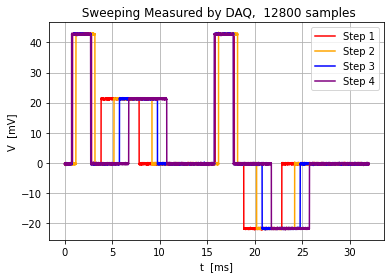

In [8]:
#for stepp in range(0,len(haber)):

fig,ax= plt.subplots()

#step = 4

ax.grid(True)
plt.plot(haberms[1][1],1000*haberms[1][0],label= 'Step {st}'.format(st = 1 ),color = 'red')
plt.plot(haberms[2][1],1000*haberms[2][0],label= 'Step {st}'.format(st = 2 ),color = 'orange')
plt.plot(haberms[3][1],1000*haberms[3][0],label= 'Step {st}'.format(st = 3 ),color = 'blue')
plt.plot(haberms[4][1],1000*haberms[4][0],label= 'Step {st}'.format(st = 4 ),color = 'purple')



ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ,  {b} samples'.format(b = len(haberms[0][1]) ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse sweep t=32ms DAQ measured not so clean, 4 sweeping steps.png',bbox_inches='tight')

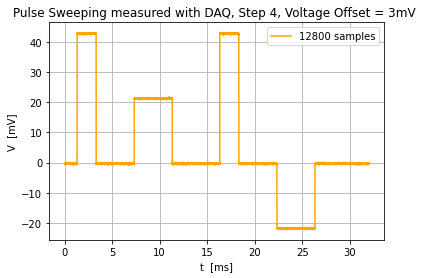

In [11]:
#dataMs, timeMs = DAQ_Measuringms(DAQ_Settings1,400000,32,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(timeMs,dataMs*1000,label= '{b} samples'.format(b=len(dataMs)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Pulse Sweeping measured with DAQ, Step 4, Voltage Offset = {value}mV '.format(value = 3))
ax.legend(loc=0)
#plt.legend(bbox_to_anchor=(2.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement offset {value}mV '.format(value = a ),bbox_inches='tight')

Triggering Pulse Stoped


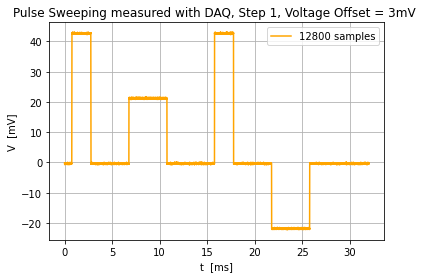

In [12]:
dataMs, timeMs = DAQ_Measuringms(DAQ_Settings1,400000,32,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(timeMs,dataMs*1000,label= '{b} samples'.format(b=len(dataMs)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Pulse Sweeping measured with DAQ, Step 1, Voltage Offset = {value}mV '.format(value = 3))
ax.legend(loc=0)
#plt.legend(bbox_to_anchor=(2.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement offset {value}mV '.format(value = a ),bbox_inches='tight')

Seconds regime

In [ ]:
def DAQ_Measurings(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(5)


    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [ ]:
DAQ_Measuring(DAQ_Settings1,1000,10,M8190A)

In [37]:
def Sequence_Loader_File_DAQ_np(instrument,DAQ_settings,sampling_rate,playingtime,fileA,fileB):
    
    """ This function loads the csv data files from the Location dictionaries into the instrument as a sequence. FOR SWEEPING

    LocationA is a dictionary, whose elements are the file paths to the csv files that are going to be loaded as SegmentA into the sequence.
    LocationB is a dictionary, whose elemnts re the filepaths to the csv files that are going to be loaded as SegmentB into the sequence
    It uses the Sequence_File function to load the csv files to the instrument.
 
    """
    measurement_data = np.zeros((len(fileA),2),  dtype=object)
    #measurement_data = {}

    for i,j,k in zip(fileA, fileB,range(0,len(fileA))):
        Sequence_File(instrument,fileA[i],fileB[j],1)
        measurement_data[k][0], measurement_data[k][1] = DAQ_Measurings(DAQ_settings,sampling_rate,playingtime,instrument)
        print('Data acquired for Step {step}'.format(step = k ))
        #instrument.write('ABOR')

    return measurement_data
    

In [43]:
M8190A.write('SEQ:DEL:ALL')

12

In [23]:
habers = Sequence_Loader_File_DAQ_np(M8190A,DAQ_Settings1,1000,20,sweeping_run[0],sweeping_run[1])

Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND


DaqError: Some or all of the samples requested have not yet been acquired.
To wait for the samples to become available use a longer read timeout or read later in your program. To make the samples available sooner, increase the sample rate. If your task uses a start trigger,  make sure that your start trigger is configured correctly. It is also possible that you configured the task for external timing, and no clock was supplied. If this is the case, supply an external clock.
Property: DAQmx_Read_RelativeTo
Corresponding Value: DAQmx_Val_CurrReadPos
Property: DAQmx_Read_Offset
Corresponding Value: 0

Task Name: _unnamedTask<16>

Status Code: -200284

Triggering Pulse Stoped


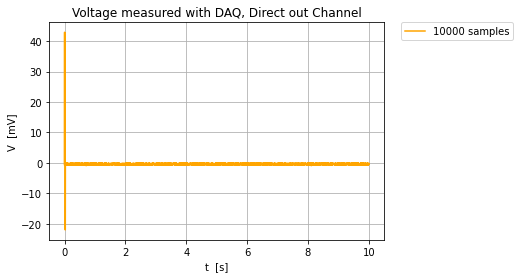

In [13]:
dataM, timeM = DAQ_Measuring(DAQ_Settings1,1000,10,M8190A)

fig,ax= plt.subplots()
ax.grid(True)

plt.plot(timeM,dataM*1000,label= '{b} samples'.format(b=len(dataM)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title('Voltage measured with DAQ, Direct out Channel')
#ax.legend(loc=0)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement noise0',bbox_inches='tight')

In [40]:
#for stepp in range(0,len(haber)):

fig,ax= plt.subplots()

#step = 4

ax.grid(True)
#plt.plot(habers[1][1],1000*habers[1][0],label= 'Step {st}'.format(st = 1 ),color = 'red')
#plt.plot(habers[2][1],1000*habers[2][0],label= 'Step {st}'.format(st = 2 ),color = 'orange')
#plt.plot(habers[3][1],1000*habers[3][0],label= 'Step {st}'.format(st = 3 ),color = 'blue')
#plt.plot(habers[4][1],1000*habers[4][0],label= 'Step {st}'.format(st = 4 ),color = 'purple')



ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ,  {b} samples'.format(b = len(habers[0][1]) ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse sweep t=32ms DAQ measured clean, 4 sweeping steps.png',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
u = np.zeros((len(sweeping_run[0]),2), dtype = object)

for i,j in zip(sweeping_run[0], sweeping_run[1]):
    for k in range(0,len(sweeping_run[0])):
        u[k][0] = k + np.ones(5)
    


In [34]:
u = np.zeros((len(sweeping_run[0]),2), dtype = object)

for i,j,k in zip(sweeping_run[0], sweeping_run[1],range(0,len(sweeping_run[0]))):
    u[k][0] = k + np.ones(5)
    u[k][1] = k*3 + np.ones(5)


In [31]:
np.ones(5) + 1

array([2., 2., 2., 2., 2.])

In [35]:
u[0]

array([array([1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1.])],
      dtype=object)

In [13]:
M8190A.write('*RST')

5

tremendos momazos


In [ ]:
Initialization(M8190A,AWG_Settings4)

desmenuzar

In [29]:
haber = Sequence_Loader_File_DAQms_np(M8190A,DAQ_Settings1,400000,32,sweeping_run[0],sweeping_run[1])

Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 0
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 1
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 2
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 3
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"
Triggering Pulse Stoped
Data acquired for Step 4


In [57]:
len(haber)

5

In [43]:
haber[3][1]

array([0.00000000e+00, 2.50019533e-03, 5.00039066e-03, ...,
       3.19949996e+01, 3.19974998e+01, 3.20000000e+01])

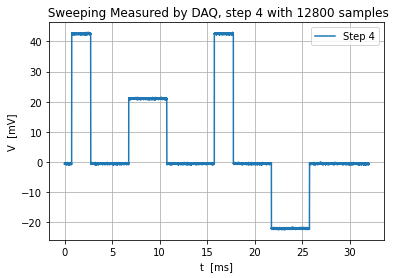

<ipython-input-56-fd91bac2e47e>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('Pulse sweep t=32ms DAQ measured at step {stp} '.format(stp =step),optimize=True,bbox_inches='tight')


In [56]:
#for stepp in range(0,len(haber)):

fig,ax= plt.subplots()

step = 4

ax.grid(True)
plt.plot(haber[step][1],1000*haber[step][0],label= 'Step {st}'.format(st = step ))

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ, step {st} with {b} samples'.format(st = step, b = len(haber[step][1]) ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse sweep t=32ms DAQ measured at step {stp} '.format(stp =step),optimize=True,bbox_inches='tight')

In [67]:
#for stepp in range(0,len(haber)):

fig,ax= plt.subplots()

#step = 4

ax.grid(True)
plt.plot(haber[1][1],1000*haber[1][0],label= 'Step {st}'.format(st = 1 ),color = 'red')
plt.plot(haber[2][1],1000*haber[2][0],label= 'Step {st}'.format(st = 2 ),color = 'orange')
plt.plot(haber[3][1],1000*haber[3][0],label= 'Step {st}'.format(st = 3 ),color = 'blue')
plt.plot(haber[4][1],1000*haber[4][0],label= 'Step {st}'.format(st = 4 ),color = 'purple')



ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ,  {b} samples'.format(st = step, b = len(haber[step][1]) ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse sweep t=32ms DAQ measured, 4 sweeping steps.png',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
u = np.zeros((len(sweeping_run[0]),2), dtype = object)

for i,j in zip(sweeping_run[0], sweeping_run[1]):
    for k in range(0,len(sweeping_run[0])):
        u[k][0] = k + np.ones(5)
    


In [8]:
sweeping_run[0]

{'Pulse File Location, at step 0': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_0.csv',
 'Pulse File Location, at step 1': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_1.csv',
 'Pulse File Location, at step 2': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_2.csv',
 'Pulse File Location, at step 3': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_3.csv',
 'Pulse File Location, at step 4': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentA_7500000_4.csv'}

In [9]:
sweeping_run[1]

{'Pulse File Location, at step 0': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_0.csv',
 'Pulse File Location, at step 1': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_1.csv',
 'Pulse File Location, at step 2': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_2.csv',
 'Pulse File Location, at step 3': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_3.csv',
 'Pulse File Location, at step 4': 'D:\\Alejandro\\Pulses\\Dict\\S4\\SegmentB_7500000_4.csv'}

In [15]:
sweeping_run[2]

{'SegmentA_7500000_0':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.057143            1              1
 2        0.057143            1              1
 3        0.057143            1              1
 4        0.057143            1              1
 ...           ...          ...            ...
 7499995  0.000000            1              1
 7499996  0.000000            1              1
 7499997  0.000000            1              1
 7499998  0.000000            1              1
 7499999  0.000000            1              1
 
 [7500000 rows x 3 columns],
 'SegmentA_7500000_1':                Y1  SyncMarker1  SampleMarker1
 0        0.000000            1              1
 1        0.057143            1              1
 2        0.057143            1              1
 3        0.057143            1              1
 4        0.057143            1              1
 ...           ...          ...            ...
 7499995  0.000000            1 

In [18]:
sweeping_run[4].size

7500000

In [42]:
haber['Data for step Pulse File Location, at step {st}'.format(st = 0 )]

array([-8.31736646e-05, -2.47801400e-04, -2.47801400e-04, ...,
       -2.47801400e-04, -2.47801400e-04, -5.77056871e-04])

In [40]:
tom = haber['Time interval for step Pulse File Location, at step 0']

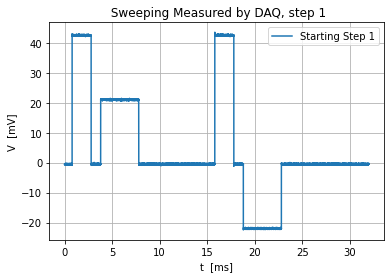

In [44]:
fig,ax= plt.subplots()

step = 1
ax.grid(True)
plt.plot(tom,1000*haber['Data for step Pulse File Location, at step {st}'.format(st = step )],label= 'Starting Step {st}'.format(st = step ))

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ, step {st}'.format(st = step ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

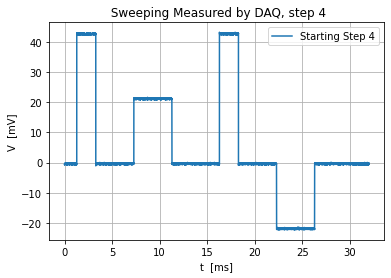

In [46]:
fig,ax= plt.subplots()

step = 4
ax.grid(True)
plt.plot(tom,1000*haber['Data for step Pulse File Location, at step {st}'.format(st = step )],label= 'Starting Step {st}'.format(st = step ))

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title(' Sweeping Measured by DAQ, step {st}'.format(st = step ))
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [19]:
def DAQ_Measuring(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(2)


    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [8]:
def Sequence_Loader_File_DAQ_np(instrument,DAQ_settings,sampling_rate,playingtime,fileA,fileB):
    
    """ This function loads the csv data files from the Location dictionaries into the instrument as a sequence. FOR SWEEPING

    LocationA is a dictionary, whose elements are the file paths to the csv files that are going to be loaded as SegmentA into the sequence.
    LocationB is a dictionary, whose elemnts re the filepaths to the csv files that are going to be loaded as SegmentB into the sequence
    It uses the Sequence_File function to load the csv files to the instrument.
 
    """
    measurement_data = np.zeros((len(fileA),2),  dtype=object)
    #measurement_data = {}

    for i,j,k in zip(fileA, fileB,range(0,len(fileA))):
        Sequence_File(instrument,fileA[i],fileB[j],1)
        measurement_data[k][0], measurement_data[k][1] = DAQ_Measuring(DAQ_settings,sampling_rate,playingtime,instrument)
        print('Data acquired for Step {step}'.format(step = k ))
        #instrument.write('ABOR')

    return measurement_data

In [ ]:
dataM, timeM = DAQ_Measuring(DAQ_Settings1,1000,10,M8190A)

In [9]:
hober = Sequence_Loader_File_DAQ_np(M8190A,DAQ_Settings1,1000,10,sweeping_run[0],sweeping_run[1])

Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 0
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 1
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 2
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 3
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999" and the advancement method is COND
Triggering Pulse Stoped
Data acquired for Step 4


In [21]:
hober[0][0].size

10000

In [25]:
tom

array([0.00000000e+00, 1.00010001e-03, 2.00020002e-03, ...,
       9.99799980e+00, 9.99899990e+00, 1.00000000e+01])

In [24]:
tom = hober[0][1]

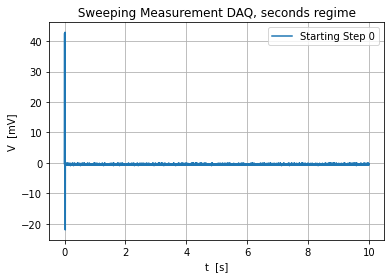

In [31]:
fig,ax= plt.subplots()

ax.grid(True)
plt.plot(tom,1000*hober[3][0],label= 'Starting Step 0')
#plt.plot(tom,1000*hober[1][0],label= '1')
#plt.plot(tom,hober[2][0],label= '2')
#plt.plot(tom,hober[3][0],label= '3')
#plt.plot(tom,hober[4][0],label= '4')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title(' Sweeping Measurement DAQ, seconds regime ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [12]:
M8190A.query('OUTP:ROUT:SEL?')

'DAC'

In [11]:
M8190A.write('OUTP:ROUT:SEL DAC')

18

In [17]:
M8190A.write('INIT:IMM')

9

voltask =  nidaqmx.Task()

voltask.ao_channels.add_ao_voltage_chan("DAQBNC1/ao1",min_val=-3,max_val=3)




print('Task started')
voltask.start()

time.sleep(10)

print('Writting!')

time.sleep(4)
voltask.write(3)
time.sleep(7) 

print('Lowering Voltage!')
time.sleep(4)

voltask.write(0)
#
voltask.stop()
#
voltask.close()

In [4]:
def Sequence_File_List1(PulseList1,P,t,N,start,stop,AWG):

    """ Given one pulse scheme list, this functions iterates the pulse scheme from start to stop.

        This function firts creates the corresponding pulse sequence data given the PulseLists using the Sweep_iteration_csv function
        
    """

    #SegmentA of the sequence
    Loc1,DF1,timm = Sweep_Iteration_CSV_List(PulseList1,P,t,N,start,stop,AWG,1)

    return Loc1, DF1, timm